### Task
* Build, train, and evaluate 2 special types of networks neural network with Pytorch.
* A CNN for a spatial prediction problem
* A RNN or LSTM for a sequential problem
* Experiment with at least 2 different variations of hyperparameters for each network.
* Optional: Use gradio to build a simple interactive demo (in the notebook)

## LSTM

# Importing required libraries


In [107]:
# pip install
!pip install tweet-preprocessor -q

In [108]:
# import required libraries
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn import preprocessing
import matplotlib.pyplot as plt
import preprocessor as prepro # twitter prepro
import re


from sklearn.model_selection import train_test_split


In [ ]:
# Data downloading
data = pd.read_json('https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pol_tweets.gz')

In [110]:
# taking 1000 datas only as it takes too long to run 
data = data[:1000]

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 340675 to 11720
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   labels  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


In [112]:
data.head()

,text,labels
340675,RT @GreenBeretFound Today we remember Sgt. 1st...,0
289492,"Yes, yes, yes, yes and yes. 😷 #JerseyStrong 💪🏾...",1
371088,Made new friends this afternoon delivering mas...,1
82212,RT @TXMilitary Happening TODAY: Pilots with th...,0
476047,RT @SteveScalise President Trump's legal team ...,0


# Preprocessing text

In [113]:
#prepro settings
prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.SMILEY, prepro.OPT.HASHTAG, prepro.OPT.EMOJI)

In [114]:
def pre_process(text):
  clean_text = text.lower()
  clean_text = re.sub('[^a-zA-Z]+ ',' ', clean_text)
  return clean_text
  

In [115]:
data['text'] = data['text'].map(lambda t: prepro.clean(t))
data['text'] = data['text'].apply(pre_process) #all in lowercase

In [116]:
data.head()

,text,labels
340675,today we remember sgt st class ryan j savard k...,0
289492,yes yes yes yes and yes qt prioritize science ...,1
371088,made new friends this afternoon delivering mas...,1
82212,happening today pilots with the texas air guar...,0
476047,president trump's legal team completely destro...,0


In [117]:
data.shape

(1000, 2)

In [118]:
data['labels'].value_counts()

1    612
0    388
Name: labels, dtype: int64

In [119]:
data.reset_index(drop = True, inplace = True)

In [120]:
data['text'] = data['text'].apply(str.split) #converting to tokens

In [121]:
data.head()

,text,labels
0,"[today, we, remember, sgt, st, class, ryan, j,...",0
1,"[yes, yes, yes, yes, and, yes, qt, prioritize,...",1
2,"[made, new, friends, this, afternoon, deliveri...",1
3,"[happening, today, pilots, with, the, texas, a...",0
4,"[president, trump's, legal, team, completely, ...",0


# Train-Test Split

In [122]:
# Splitting the dataset into the Training set and Test set
train, test = train_test_split(data, test_size=0.3)

In [123]:
print(train.shape)
print(test.shape)

(700, 2)
(300, 2)


In [124]:
train = train.to_numpy()
test = test.to_numpy()

In [125]:
type(train)

numpy.ndarray

In [126]:
train = [(tokens, label) for tokens, label in train]
test = [(tokens, label) for tokens, label in test]


In [127]:
print(train[0])

(['generation', 'ratify', 'virginia', 'appreciates', 'steadfast', 'commitment', 'to', 'the', 'fight', 'for', 'gender', 'equality', '&amp', 'the', 'era', 'if', 're-elected', 'he', 'will', 'persist', 'as', 'an', 'advocate', 'for', 'gender', 'equality', '&amp', 'the', 'era', 'in', 'the', 'u.s', 'senate', 'we', 'love', 'sen', 'warner', 'link', 'in', 'bio', 'to', 'find', 'out', 'more!'], 1)


In [128]:
vocab = { }
vocab['<PAD>'] = len(vocab)
vocab['<UNK>'] = len(vocab)
for text, label in train:
  for word in text:
    if word not in vocab:
      vocab[word]= len(vocab)

In [129]:
vocab['<PAD>']

0

In [130]:
len(vocab)

5142

In [131]:
#converting tokens into numeric
train_text = []
train_label = []
N = 75
for tokens, label in train:
  train_label.append(label)
  temp = np.zeros(N, dtype = int)
  for i, t in enumerate(tokens[:N]):
    if t in vocab:
      temp[i] = vocab[t]
    else:
      temp[i] = vocab['<UNK>']
  train_text.append(temp)

In [132]:
#converting tokens into numeric
test_text = []
test_label = []
for tokens, label in test:
  test_label.append(label)
  temp = np.zeros(N, dtype = int)
  for i, t in enumerate(tokens[:N]):
    if t in vocab:
      temp[i] = vocab[t]
    else:
      temp[i] = vocab['<UNK>']
  test_text.append(temp)

In [133]:
train_text[:3]


[array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  9, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 11, 12, 13, 14,  9, 15, 24,  9, 25, 26, 27,
        28, 29, 30, 31, 24, 32,  8, 33, 34, 35,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0]),
 array([24, 36, 37,  9, 38, 39, 40, 41, 42, 43, 44,  9, 45, 46, 47, 48, 49,
        50, 47, 51, 52, 53, 54, 37, 55, 56, 43, 57, 58,  9, 59,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0]),
 array([16, 60, 61, 62, 63, 37, 64, 65, 66, 67, 62, 68, 69,  9, 61, 22, 70,
        71, 72, 73,  9, 74, 50, 75, 76, 77, 78, 72, 46, 79, 34, 37, 65, 80,
        22, 81, 82,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 

In [134]:
train_label[:3]

[1, 1, 0]

In [135]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(np.array(train_text)), torch.from_numpy(np.array(train_label)))
test_data = TensorDataset(torch.from_numpy(np.array(test_text)), torch.from_numpy(np.array(test_label)))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [136]:
train_data[0]

(tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  9, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 11, 12, 13, 14,  9, 15, 24,  9, 25, 26, 27, 28, 29,
         30, 31, 24, 32,  8, 33, 34, 35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]), tensor(1))

# Training LSTM model three hidden layer 

In [137]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 50
hidden_size = 3
output_size = 1
num_epochs = 50

# 1. Creating a LSTM model
# Define the LSTM model and Linear output fully connected layer
embed = nn.Embedding(len(vocab), input_size, padding_idx=0)
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)



## Using SGD as an optimiser

In [138]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

In [139]:
# Initializing Hyperparameters
num_epochs = 50
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    print('epochs:',epoch)
    train_loss = 0

    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, 1, hidden_size)
    cs = torch.zeros(1, 1, hidden_size)
    
    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        label = label.view(-1, 1, 1)
        hidden = (hs, cs)
        # Run the forward pass
        embeddings = embed(data)
        output, hidden = lstm(embeddings, hidden)
        output = fc(hidden[-1])
        
        # 2. Network Evaluation
        loss = criterion(output, label.float())
        hs = hs.detach()
        cs = cs.detach()

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)


epochs: 0
epochs: 1
epochs: 2
epochs: 3
epochs: 4
epochs: 5
epochs: 6
epochs: 7
epochs: 8
epochs: 9
epochs: 10
epochs: 11
epochs: 12
epochs: 13
epochs: 14
epochs: 15
epochs: 16
epochs: 17
epochs: 18
epochs: 19
epochs: 20
epochs: 21
epochs: 22
epochs: 23
epochs: 24
epochs: 25
epochs: 26
epochs: 27
epochs: 28
epochs: 29
epochs: 30
epochs: 31
epochs: 32
epochs: 33
epochs: 34
epochs: 35
epochs: 36
epochs: 37
epochs: 38
epochs: 39
epochs: 40
epochs: 41
epochs: 42
epochs: 43
epochs: 44
epochs: 45
epochs: 46
epochs: 47
epochs: 48
epochs: 49


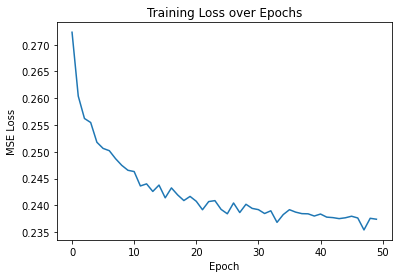

In [140]:
# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()
     

In [141]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, 1, hidden_size)
    cs = torch.zeros(1, 1, hidden_size)

    for data, label in test_loader:
        label = label.view(-1, 1, 1)
        hidden = (hs, cs)
        embeddings = embed(data)
        output, hidden = lstm(embeddings, hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.2371307219588198


In [142]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt_sgd3')


## Using AdamW as an optimiser

In [143]:

# Define the loss function and optimizer
criterion = nn.MSELoss()
#optimizer = optim.SGD(lstm.parameters(), lr=0.01)
optimizer = optim.AdamW(lstm.parameters(), lr=0.01)


In [144]:
# Initializing Hyperparameters
num_epochs = 50
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    print('epochs:',epoch)
    train_loss = 0

    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, 1, hidden_size)
    cs = torch.zeros(1, 1, hidden_size)
    
    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        label = label.view(-1, 1, 1)
        hidden = (hs, cs)
        # Run the forward pass
        embeddings = embed(data)
        output, hidden = lstm(embeddings, hidden)
        output = fc(hidden[-1])
        
        # 2. Network Evaluation
        loss = criterion(output, label.float())
        hs = hs.detach()
        cs = cs.detach()

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)


epochs: 0
epochs: 1
epochs: 2
epochs: 3
epochs: 4
epochs: 5
epochs: 6
epochs: 7
epochs: 8
epochs: 9
epochs: 10
epochs: 11
epochs: 12
epochs: 13
epochs: 14
epochs: 15
epochs: 16
epochs: 17
epochs: 18
epochs: 19
epochs: 20
epochs: 21
epochs: 22
epochs: 23
epochs: 24
epochs: 25
epochs: 26
epochs: 27
epochs: 28
epochs: 29
epochs: 30
epochs: 31
epochs: 32
epochs: 33
epochs: 34
epochs: 35
epochs: 36
epochs: 37
epochs: 38
epochs: 39
epochs: 40
epochs: 41
epochs: 42
epochs: 43
epochs: 44
epochs: 45
epochs: 46
epochs: 47
epochs: 48
epochs: 49


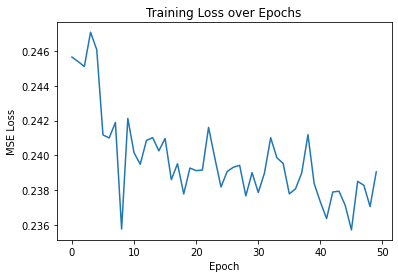

In [145]:
# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()
     

In [146]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, 1, hidden_size)
    cs = torch.zeros(1, 1, hidden_size)

    for data, label in test_loader:
        label = label.view(-1, 1, 1)
        hidden = (hs, cs)
        embeddings = embed(data)
        output, hidden = lstm(embeddings, hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.2429755281905333


In [147]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt_adam3')


# Training Model with 6 Hidden Layer 

In [148]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 50
hidden_size = 6
output_size = 1
num_epochs = 50

# 1. Creating a LSTM model
# Define the LSTM model and Linear output fully connected layer
embed = nn.Embedding(len(vocab), input_size, padding_idx=0)
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)


## Using SGD as an optimiser

In [149]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

In [150]:
# Initializing Hyperparameters
num_epochs = 50
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    print('epochs:',epoch)
    train_loss = 0

    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, 1, hidden_size)
    cs = torch.zeros(1, 1, hidden_size)
    
    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        label = label.view(-1, 1, 1)
        hidden = (hs, cs)
        # Run the forward pass
        embeddings = embed(data)
        output, hidden = lstm(embeddings, hidden)
        output = fc(hidden[-1])
        
        # 2. Network Evaluation
        loss = criterion(output, label.float())
        hs = hs.detach()
        cs = cs.detach()

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

epochs: 0
epochs: 1
epochs: 2
epochs: 3
epochs: 4
epochs: 5
epochs: 6
epochs: 7
epochs: 8
epochs: 9
epochs: 10
epochs: 11
epochs: 12
epochs: 13
epochs: 14
epochs: 15
epochs: 16
epochs: 17
epochs: 18
epochs: 19
epochs: 20
epochs: 21
epochs: 22
epochs: 23
epochs: 24
epochs: 25
epochs: 26
epochs: 27
epochs: 28
epochs: 29
epochs: 30
epochs: 31
epochs: 32
epochs: 33
epochs: 34
epochs: 35
epochs: 36
epochs: 37
epochs: 38
epochs: 39
epochs: 40
epochs: 41
epochs: 42
epochs: 43
epochs: 44
epochs: 45
epochs: 46
epochs: 47
epochs: 48
epochs: 49


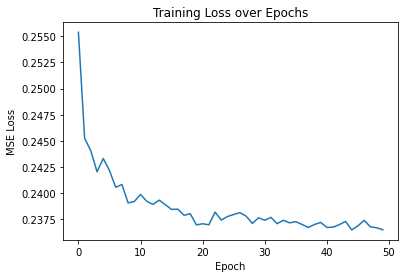

In [151]:
# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()
     

In [152]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, 1, hidden_size)
    cs = torch.zeros(1, 1, hidden_size)

    for data, label in test_loader:
        label = label.view(-1, 1, 1)
        hidden = (hs, cs)
        embeddings = embed(data)
        output, hidden = lstm(embeddings, hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.22548099341103808


In [153]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt_Sgd6')


## Using AdamW as an opimiser

In [154]:

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(lstm.parameters(), lr=0.01)

In [155]:
# Initializing Hyperparameters
num_epochs = 50
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    print('epochs:',epoch)
    train_loss = 0

    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, 1, hidden_size)
    cs = torch.zeros(1, 1, hidden_size)
    
    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        label = label.view(-1, 1, 1)
        hidden = (hs, cs)
        # Run the forward pass
        embeddings = embed(data)
        output, hidden = lstm(embeddings, hidden)
        output = fc(hidden[-1])
        
        # 2. Network Evaluation
        loss = criterion(output, label.float())
        hs = hs.detach()
        cs = cs.detach()

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

epochs: 0
epochs: 1
epochs: 2
epochs: 3
epochs: 4
epochs: 5
epochs: 6
epochs: 7
epochs: 8
epochs: 9
epochs: 10
epochs: 11
epochs: 12
epochs: 13
epochs: 14
epochs: 15
epochs: 16
epochs: 17
epochs: 18
epochs: 19
epochs: 20
epochs: 21
epochs: 22
epochs: 23
epochs: 24
epochs: 25
epochs: 26
epochs: 27
epochs: 28
epochs: 29
epochs: 30
epochs: 31
epochs: 32
epochs: 33
epochs: 34
epochs: 35
epochs: 36
epochs: 37
epochs: 38
epochs: 39
epochs: 40
epochs: 41
epochs: 42
epochs: 43
epochs: 44
epochs: 45
epochs: 46
epochs: 47
epochs: 48
epochs: 49


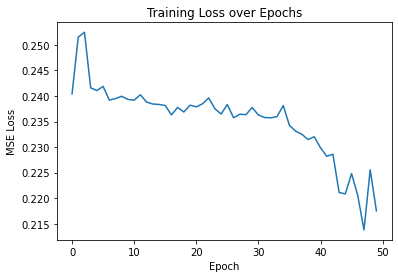

In [156]:
# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()
     

In [157]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, 1, hidden_size)
    cs = torch.zeros(1, 1, hidden_size)

    for data, label in test_loader:
        label = label.view(-1, 1, 1)
        hidden = (hs, cs)
        embeddings = embed(data)
        output, hidden = lstm(embeddings, hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.24941943890725574


In [158]:

# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt_adam6')


###Output: 

hiden layer = 6 , optimiser = SGD , MSE = 0.225

hiden layer = 6 , optimiser = AdamW , MSE = 0.242

hiden layer = 3 , optimiser = SGD , MSE = 0.237

hiden layer = 3 , optimiser = AdamW , MSE = 0.278



In [159]:
# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt_Sgd6'))


<All keys matched successfully>